In [75]:
TRAIN_SET_PATH = "./dataset/train.csv"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [76]:
train_set = pd.read_csv(TRAIN_SET_PATH, index_col=0)
features_names = list(train_set.columns)
n_features = len(features_names)
n_samples = len(train_set)

print("The dataset has the following %d features:" % n_features)
print(", ".join(features_names), end="\n\n")
print("In total there are %d samples in the dataset." % n_samples)

The dataset has the following 21 features:
A1_Score, A2_Score, A3_Score, A4_Score, A5_Score, A6_Score, A7_Score, A8_Score, A9_Score, A10_Score, age, gender, ethnicity, jaundice, austim, contry_of_res, used_app_before, result, age_desc, relation, Class/ASD

In total there are 800 samples in the dataset.


In [77]:
train_set.rename(columns = {'age':'Age', 'gender': 'Gender', 'ethnicity': 'Ethnicity', 'jaundice': 'Jaundice', 'austim':'Autism', 
                            'contry_of_res': 'Country_of_Res', 'used_app_before': 'Used_App_Before', 'result': 'Result', 'age_desc': 'Age_Desc', 'relation': 'Relation'}, inplace = True)

## Description of the dataset's features

* ID
    + It's the ID of the patient, loaded as index of the dataframe
    
* A1_Score to A10_Score
    + Score based on Autism Spectrum Quotient (AQ) 10 item screening tool.
    + This screening tool makes use of a list of 10 questions, such as "I often notice small sounds when others do not", or "I know how to tell if someone listening to me is getting bored", to which the subject can answer one of the following:
        1. Definitely Agree
        2. Slightly Agree
        3. Slightly Disagree
        4. Definitely Disagree
    + A single point is assigned to the questions 1, 7, 8, and 10 if the answer is either "Definitely Agree" or "Slightly Agree". For the remaining questions, a single point is assigned if the answer is either "Definitely Disagree" or "Slightly Disagree". Therefore these features are binary.
    + This test shall never be considered conclusive, and in general whenever the subject scores 6 or more points it is an indication of a possible disorder falling in the spectrum of autism.

* Age
    + The age of the patient in years.
    + This is a continuous numerical feature, which could be modeled by some continuous distribution probability (as Gaussian linear), but in order to handle it in pgmpy it is probably better to discretize it.

* Gender
    + The gender of the patient.
    + Categorical variable, either "f" or "m".

* Ethnicity
    + Ethnicity of the patient.
    + Cathegorical variable, examples of ethnicity are "White-European" or "Middle Eastern"

* Jaundice
    + Whether the patient had jaundice at the time of the birth.
    + Jaundices at birth time are often associated with autism.
    + Binary variable.
    
* Autism
    + Whether an immediate family member has been diagnosed with autism.
    + Autism can have genetic bases.
    + Binary variable.

* Country_of_res
    + Country of residence of the patient.
    + Not sure about the potential predictive role of this feature, it seems unrealistic to have a correlation between living in a certain country and having an autistic disorder. In addition, provided there was any correlation, if the dataset is not perfectly balanced considering such variable would be completely detrimental. Further analysis is needed to decide whether to include it or not.
    + Categorical variable.
    
* Used_app_before
    + Whether the patient has undergone a screening test before.
    + Potentially having took a screening test before could influence the output of the following tests. In addition, it could be an indicator of potential pre-exsisting worries of the patient or of its parents. I will analyze how this features correlates with the target variable to get better insights.
    + Binary variable.

* Result
    + Score for the AQ1-10 screening test.
    + Not sure about how the score was computed, since it is not stated anywhere. In addition, since it is derived from other variables it could be not worth to include it. 
    + It is a continuous numerical attribute, therefore it should be discretized.

* Relation
    + Relation of patient who completed the test.
    + Potentially the test could be completed by one relative of the patient, like his/her father or mother.
    + The possible values are "Self" or "Relative".

* Age_desc
    + Description in words of patient's age.
    + This is a useless attributes and therefore it will be removed.

* Class/ASD
    + Classified result as 0 or 1. 0 represents no autism.
    + This is the target variable

## Analysis of features


In [78]:
print("The possible countries of residence found in the train set are: ", ", ".join(train_set.Country_of_Res.unique()))

The possible countries of residence found in the train set are:  Austria, India, United States, South Africa, Jordan, United Kingdom, Brazil, New Zealand, Canada, Kazakhstan, United Arab Emirates, Australia, Ukraine, Iraq, France, Malaysia, Viet Nam, Egypt, Netherlands, Afghanistan, Oman, Italy, AmericanSamoa, Bahamas, Saudi Arabia, Ireland, Aruba, Sri Lanka, Russia, Bolivia, Azerbaijan, Armenia, Serbia, Ethiopia, Sweden, Iceland, Hong Kong, Angola, China, Germany, Spain, Tonga, Pakistan, Iran, Argentina, Japan, Mexico, Nicaragua, Sierra Leone, Czech Republic, Niger, Romania, Cyprus, Belgium, Burundi, Bangladesh


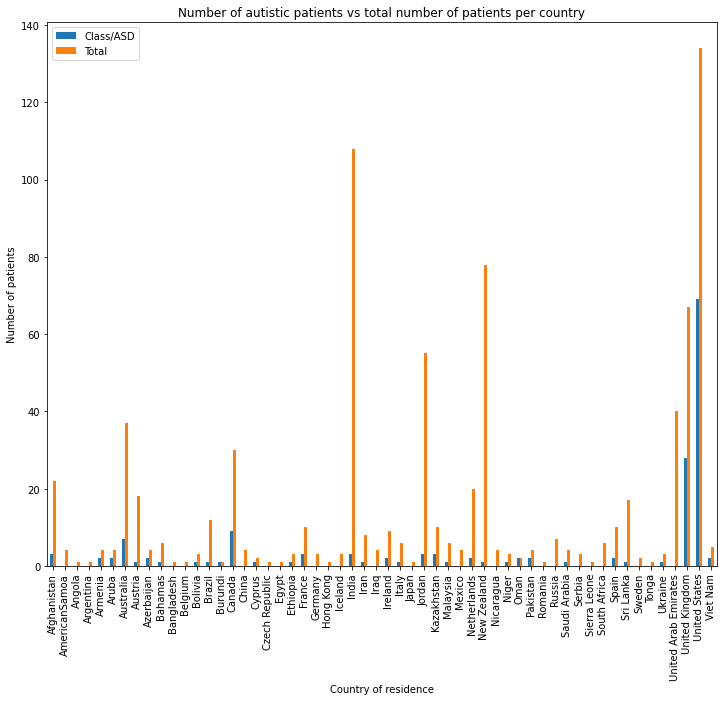

In [79]:
train_set["Total"] = [1] * n_samples
country_of_res_bar_plot = train_set.groupby("Country_of_Res")[["Class/ASD", "Total"]].sum()
country_of_res_bar_plot.plot(kind='bar', title='Number of autistic patients vs total number of patients per country', ylabel='Number of patients', xlabel='Country of residence', figsize=(12, 10))
train_set.drop("Total", inplace=True, axis=1)

In [80]:
print("The possible ethnicities found in the train set are: ", ", ".join(train_set.Ethnicity.unique()))

The possible ethnicities found in the train set are:  ?, White-European, Middle Eastern , Pasifika, Black, Others, Hispanic, Asian, Turkish, South Asian, Latino, others


In [81]:
# ? stands for unknown ethnicity, while Others and others being actually the same can be incorporated
train_set["Ethnicity"] = train_set["Ethnicity"].str.replace("?", "Unknown", regex=False).replace("others", "Others", regex=False)

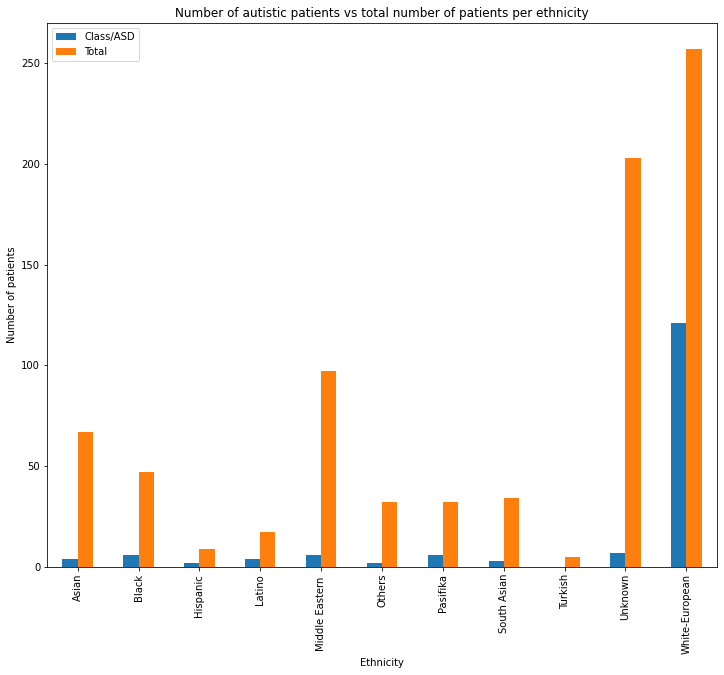

In [82]:
train_set["Total"] = [1] * n_samples
country_of_res_bar_plot = train_set.groupby("Ethnicity")[["Class/ASD", "Total"]].sum()
country_of_res_bar_plot.plot(kind='bar', title='Number of autistic patients vs total number of patients per ethnicity', ylabel='Number of patients', xlabel='Ethnicity', figsize=(12, 10))
train_set.drop("Total", inplace=True, axis=1)

In [89]:
train_set["Used_App_Before"] = pd.Categorical(train_set["Used_App_Before"]).codes
train_set["Jaundice"] = pd.Categorical(train_set["Jaundice"]).codes
train_set["Gender"] = pd.Categorical(train_set["Gender"]).codes
train_set["Autism"] = pd.Categorical(train_set["Autism"]).codes
train_set["Relation_Code"] = pd.Categorical(train_set["Relation"]).codes

In [83]:
train_set.Relation.unique()

array(['Self', 'Relative', 'Parent', '?', 'Others',
       'Health care professional'], dtype=object)